_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Student name: Harald Kugler, Leander Zimmermann

# Coding Lab 3

- __Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

Two-photon imaging is widely used to study computations in populations of neurons. In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For analysis, please resample it to 25 Hz using `scipy.signal.decimate`.

In [137]:
from __future__ import annotations

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-05-04 18:03:26CEST

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.12.0

sklearn: 1.2.2

pandas    : 2.0.0
numpy     : 1.24.2
seaborn   : 0.12.2
scipy     : 1.10.1
matplotlib: 3.7.1

Watermark: 2.3.1



In [138]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [139]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)

In [140]:
ogb_calcium.shape, ogb_spikes.shape, gcamp_calcium.shape, gcamp_spikes.shape

((71986, 11), (71986, 11), (23973, 37), (23973, 37))

In [141]:
ogb_calcium.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.234928,0.689186,2.578560,0.636770,-0.015140,0.819771,2.442105,0.391310,0.223523,1.557675,0.625052
1,-0.182441,0.869132,2.868601,0.596164,0.022464,0.831411,2.930201,0.490213,0.116095,1.628054,0.638718
2,-0.049257,0.949273,2.784989,0.711875,0.040028,0.877191,3.065872,0.610873,0.154437,1.479382,0.552809
3,-0.032876,0.848802,2.430735,0.940943,0.038616,0.975941,3.051014,0.714453,0.335288,1.302766,0.420998
4,-0.125313,0.665088,2.064211,1.168007,0.014035,1.156689,2.967063,0.737085,0.550485,1.234470,0.367595


In [142]:
ogb_spikes.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
1,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
2,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
3,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
4,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0


In [143]:
ogb_calcium_25Hz = ogb_calcium.iloc[::4, :]
ogb_spikes_25Hz = ogb_spikes.iloc[::4, :]
gcamp_calcium_25Hz = gcamp_calcium.iloc[::4, :]
gcamp_spikes_25Hz = gcamp_spikes.iloc[::4, :]
ogb_calcium_25Hz.shape[0], ogb_calcium.shape[0] // 4

fs = 25  # Hz
dt = 1 / fs  # seconds

## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Zoom in on a small segment of tens of seconds and offset the traces such that a valid comparison is possible.

*Grading: 2 pts*

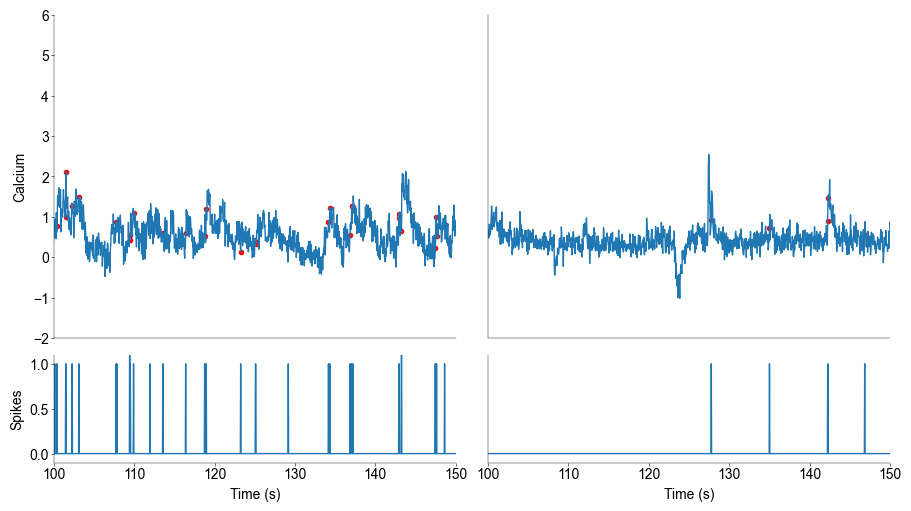

In [191]:
# ----------------------------
# Plot raw calcium data (1 pt)
# ----------------------------
def plot_calcium(ax, calcuim_data, cell_i):
    cell_data = calcuim_data.iloc[:, cell_i]
    t = np.arange(cell_data.shape[0]) * dt
    ax.plot(t, cell_data, label=f"{cell_i}")


# --------------------------
# Plot raw spike data (1 pt)
# --------------------------
def plot_spikes(ax, spike_data, cell_i):
    cell_data = spike_data.iloc[:, cell_i]
    t = np.arange(cell_data.shape[0]) * dt
    ax.plot(t, cell_data, label=f"{cell_i}")
    ax.set_xlabel("Time (s)")


def scatter_spikes(ax, spike_data, calcium_data, cell_i):
    spike_cell = spike_data.iloc[:, cell_i]
    indices = np.where(spike_cell > 0)[0]
    ax.scatter(
        indices * dt,
        calcium_data.iloc[indices, cell_i],
        label=f"{cell_i}",
        color="red",
    )


fig, axs = plt.subplots(
    2, 2, figsize=(9, 5), height_ratios=[3, 1], layout="constrained"
)

OGB_CELL = 5
GCAMP_CELL = 6
WINDOW = 50  # in seconds
START = 150  # in seconds

for i, ax in enumerate(axs.T):
    for a in ax:
        if i == 1:
            a.set_yticks([])
        a.set_xlim(START, START + WINDOW)
    ax[0].set_ylim(-2, 6)
    ax[1].set_ylim(-0.1, 1.1)
    ax[0].set_xticks([])

axs[0, 0].set_ylabel("Calcium")
axs[1, 0].set_ylabel("Spikes")
# plot raw ogb data
plot_calcium(axs[0, 0], ogb_calcium_25Hz, OGB_CELL)
plot_spikes(axs[1, 0], ogb_spikes_25Hz, OGB_CELL)
scatter_spikes(axs[0, 0], ogb_spikes_25Hz, ogb_calcium_25Hz, OGB_CELL)

# plot raw gcamp data
plot_calcium(axs[0, 1], gcamp_calcium_25Hz, GCAMP_CELL)
plot_spikes(axs[1, 1], gcamp_spikes_25Hz, GCAMP_CELL)
scatter_spikes(axs[0, 1], gcamp_spikes_25Hz, gcamp_calcium_25Hz, GCAMP_CELL)

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). As we know that there can be no negative rates, apply a heavyside function to the output. Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this.

*Grading: 3 pts*


In [164]:
def deconv_ca(ca, tau, dt):
    """Compute the deconvolution of the calcium signal.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    tau: float
        decay constant of conv kernel

    dt: float
        sampling interval.

    Return
    ------

    sp_hat: np.array
    """

    # insert your code here

    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # --------------------------------------------
    kernel_len = 10  # in seconds (choose something that is much longer than the kernel has support)
    x = np.linspace(0, kernel_len, fs * kernel_len)
    kernel = np.exp(-x / tau)
    sp_hat, _ = signal.deconvolve(ca, kernel)
    return sp_hat

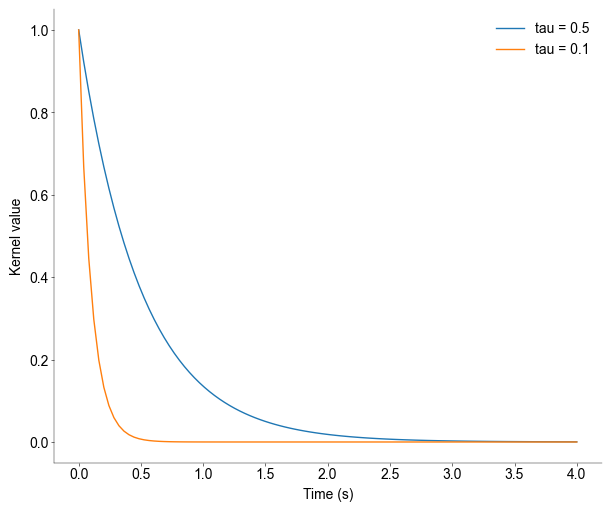

In [181]:
fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")

# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------
WINDOW = 4
x = np.linspace(0, WINDOW, fs * WINDOW)
kernel_1 = np.exp(-x / 0.5)
kernel_2 = np.exp(-x / 0.1)
ax.plot(x, kernel_1, label="tau = 0.5")
ax.plot(x, kernel_2, label="tau = 0.1")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Kernel value")
ax.legend()

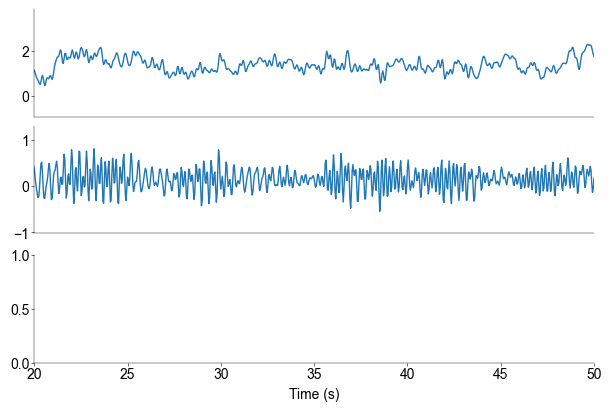

In [187]:
# --------------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB or GCamP Cell (1 pt)
# --------------------------------------------------------------------------
START = 20
WINDOW = 30

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell
# axs[0].plot(ogb_calcium.iloc[:, OGB_CELL], label="true")
plot_calcium(axs[0], ogb_calcium, OGB_CELL)
y = deconv_ca(ogb_calcium.iloc[:, OGB_CELL], 0.5, 0.01)
plot_calcium(axs[1], pd.DataFrame(y), 0)
plot_spikes(axs[2], ogb_spikes, OGB_CELL)   

for i, ax in enumerate(axs):
    ax.set_xlim(START, START + WINDOW)
    if i != 2:
        ax.set_xticks([])
    else:
        ax.set_xlabel("Time (s)")

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 2 pts*



In [148]:
# run this cell to download the oopsi.py file if you haven't already mannually downloaded it
# and put it in the same folder as this notebook
# !wget https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py
!curl https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py -o oopsi.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7973  100  7973    0     0  18447      0 --:--:-- --:--:-- --:--:-- 18672


In [149]:
import oopsi

In [150]:
# --------------------------------------------------------------
# Apply one of the advanced algorithms on the OGB Cell (0.5 pts)
# --------------------------------------------------------------

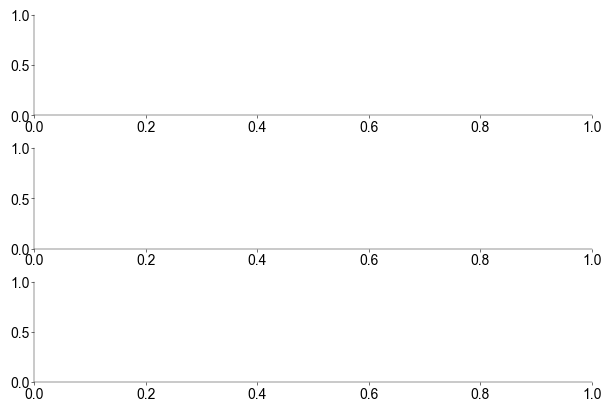

In [151]:
# -------------------------------------------
# Plot the results for the OGB Cell (0.5 pts)
# -------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell

In [152]:
# ----------------------------------------------------------------
# Apply one of the advanced algorithms on the GCamP Cell (0.5 pts)
# ----------------------------------------------------------------

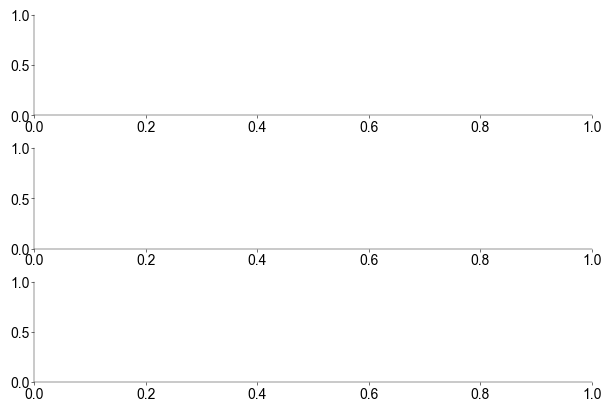

In [153]:
# ---------------------------------------------
# Plot the results for the GCamp Cell (0.5 pts)
# ---------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)


# GCamP Cell

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package.

*Grading: 3 pts*


Evaluate on OGB data

In [154]:
# -------------------------------------------------
# Create dataframe for OGB Cell as described (1 pt)
# -------------------------------------------------

Create OGB dataframe

In [155]:
df_ogb = pd.DataFrame({"algorithm": algo, "correlation": c, "indicator": indicator})
df_ogb.head()

NameError: name 'algo' is not defined

Evaluate on GCamp data

In [ ]:
# ---------------------------------------------------
# Create dataframe for GCamP Cell as described (1 pt)
# ---------------------------------------------------

Create GCamp dataframe

In [ ]:
df_gcamp = pd.DataFrame({"algorithm": algo, "correlation": c, "indicator": indicator})
df_gcamp.head()

Combine both dataframes and plot

In [ ]:
# ---------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described (1 pt)
# hint: you can seperate the algorithms by color
# ---------------------------------------------------------------------------